In [1]:
import numpy as np
import pandas as pd
from scipy import stats as stats
import scipy.integrate as sint

In [24]:
x = np.arange(6)[:]
x0 = np.concatenate([[x[-2]], [x[-1]], x[:], [x[0]]])
x0
y1 = x0[0:-3]
y2 = x0[1:-2]
y3 = x0[2:-1]
y4 = x0[3:]
y1, y2, y3, y4


(array([4, 5, 0, 1, 2, 3]),
 array([5, 0, 1, 2, 3, 4]),
 array([0, 1, 2, 3, 4, 5]),
 array([1, 2, 3, 4, 5, 0]))

In [ ]:
def create_periodic(sigma, m, dx):
      if m % 2 == 0: #Even
            cx = m/2
            x = np.concatenate([np.arange(0, cx), np.arange(cx, 0, -1), np.arange(0, cx), np.arange(cx, 0, -1)])
      else: #Odd
            cx = np.floor(m/2)
            x = np.concatenate([np.arange(0, cx+1), np.arange(cx, 0, -1), np.arange(0, cx+1), np.arange(cx, 0, -1)])
      wlc = np.exp(-((dx*(x))**2)/(2*sigma*2))
      B = np.zeros((m, m))
      for i in range(m):
            B[i, :] = wlc[m - i:2*m - i]
      B = np.where(B < 0, 0, B)
      return B

def M_nl96(x, dt, T, kwargs):
      F = kwargs['F']
      Nx = x.shape[0]
      def dxt(x0, F):
            x0 = np.concatenatea([x0[-2, :], x0[-1, :], x0[:, 0], x0[0, :]])
            y1 = x0[0:-3]
            y2 = x0[1:-2]
            y3 = x0[2:-1]
            y4 = x0[3:]
            x1 = -y2*(y1-y4) - y3 + F
            return x1
      x = x[:, 0]
      for t in range(T):
            k1 = dt*dxt(x, F)
            k2 = dt*dxt(x + k1/2, F)
            k3 = dt*dxt(x + k2/2, F)
            k4 = dt*dxt(x + k3, F)
            x = x + k1/6 + k2/3 + k3/3 + k4/6
      return x[:, np.newaxis]


def M_l96(x, dt, T, kwargs):
      F = kwargs['F']
      Nx = x.shape[0]
      x2 = x
      for t in range(T):
            dxs = np.zeros((Nx,))
            for i in range(Nx):
                  if i == Nx-1:
                        dxs[i] = (x[0] - x[i-2])*x[i-1] - x[i] + F
                  else:      
                        dxs[i] = (x[i+1] - x[i-2])*x[i-1] - x[i] + F
            x = x2 + dxs*dt
            x2 = x
      return x   

def M_lin(x, M, T = 1):
      x_ret = x
      for t in range(T):
            x_ret = np.matmul(M, x_ret)
      return x_ret

In [3]:
n = 7
M = np.zeros((n, n))
M[np.arange(0, n), np.arange(0, n)] = 1
M[np.arange(1, n), np.arange(0, n-1)] = 0.5
M[np.arange(0, n-1), np.arange(1, n)] = 0.5
M[np.arange(2, n), np.arange(0, n-2)] = -0.5
M[np.arange(0, n-2), np.arange(2, n)] = -0.5
M[n-1, 0] = 0.5
M[0, n-1] = 0.5
M[np.arange(n-2, n), np.arange(0, 2)] = -0.5
M[np.arange(0, 2), np.arange(n-2, n)] = -0.5
vals, vec = np.linalg.eig(M)
M

array([[ 1. ,  0.5, -0.5,  0. ,  0. , -0.5,  0.5],
       [ 0.5,  1. ,  0.5, -0.5,  0. ,  0. , -0.5],
       [-0.5,  0.5,  1. ,  0.5, -0.5,  0. ,  0. ],
       [ 0. , -0.5,  0.5,  1. ,  0.5, -0.5,  0. ],
       [ 0. ,  0. , -0.5,  0.5,  1. ,  0.5, -0.5],
       [-0.5,  0. ,  0. , -0.5,  0.5,  1. ,  0.5],
       [ 0.5, -0.5,  0. ,  0. , -0.5,  0.5,  1. ]])

In [4]:
np.random.seed(1)
x = np.random.randn(n, 1)

In [5]:
Pa = np.eye(n)
Pa[np.arange(1, n), np.arange(0, n-1)] = 0.5
Pa[np.arange(0, n-1), np.arange(1, n)] = 0.5
Xma = np.zeros(n)

In [6]:
rho_0 = stats.multivariate_normal(Xma, Pa)

Try to calculate the forecast error covariance using theory

In [7]:
Pf_theory = np.matmul(M, np.matmul(Pa, M.T))

Try using a MCMC method

In [8]:
times = 1000
final_Pa_est = np.zeros((n,n))
final_Pf_est = np.zeros((n,n))

for t in range(times):
      Ne = 100000
      Xa = rho_0.rvs(Ne).T
      Xf = np.matmul(M, Xa)
      xma = np.mean(Xa, axis = 1)
      xmf = np.mean(Xf, axis = 1)
      Xa_p = (1/np.sqrt(Ne-1))*(Xa - xma[:, np.newaxis])
      Xf_p = (1/np.sqrt(Ne-1))*(Xf - xmf[:, np.newaxis])
      Pa_est = np.matmul(Xa_p, Xa_p.T)
      Pf_est = np.matmul(Xf_p, Xf_p.T)
      final_Pa_est += Pa_est
      final_Pf_est += Pf_est

final_Pa_est = final_Pa_est*(1/times)
final_Pf_est = final_Pf_est*(1/times)

In [9]:
final_Pa_est - Pa

array([[-1.09438742e-04, -1.52393689e-04, -3.00741775e-05,
        -9.81262356e-05, -4.28822746e-05,  1.91041066e-04,
         1.98239817e-04],
       [-1.52393689e-04, -6.29416777e-05,  2.74012959e-05,
        -1.07961586e-04,  2.78469637e-05,  2.65537133e-04,
         2.48151600e-04],
       [-3.00741775e-05,  2.74012959e-05,  5.33516650e-05,
         5.73133818e-06,  2.16241067e-05,  1.93181163e-04,
         2.39374306e-04],
       [-9.81262356e-05, -1.07961586e-04,  5.73133818e-06,
         1.75995645e-05, -1.30348053e-04,  7.08215910e-05,
         1.19071803e-04],
       [-4.28822746e-05,  2.78469637e-05,  2.16241067e-05,
        -1.30348053e-04, -1.62006451e-04, -2.96599393e-05,
         7.27174296e-06],
       [ 1.91041066e-04,  2.65537133e-04,  1.93181163e-04,
         7.08215910e-05, -2.96599393e-05, -1.35746652e-04,
        -8.04534422e-05],
       [ 1.98239817e-04,  2.48151600e-04,  2.39374306e-04,
         1.19071803e-04,  7.27174296e-06, -8.04534422e-05,
        -2.0506385

In [10]:
np.round(final_Pf_est, 2) , Pf_theory
np.round(final_Pa_est, 2), Pa

(array([[ 1. ,  0.5, -0. , -0. , -0. ,  0. ,  0. ],
        [ 0.5,  1. ,  0.5, -0. ,  0. ,  0. ,  0. ],
        [-0. ,  0.5,  1. ,  0.5,  0. ,  0. ,  0. ],
        [-0. , -0. ,  0.5,  1. ,  0.5,  0. ,  0. ],
        [-0. ,  0. ,  0. ,  0.5,  1. ,  0.5,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0.5,  1. ,  0.5],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  1. ]]),
 array([[1. , 0.5, 0. , 0. , 0. , 0. , 0. ],
        [0.5, 1. , 0.5, 0. , 0. , 0. , 0. ],
        [0. , 0.5, 1. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0.5, 1. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0.5, 1. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0.5, 1. , 0.5],
        [0. , 0. , 0. , 0. , 0. , 0.5, 1. ]]))

Now let's try the SV methodology with varying ensemble size

In [57]:
D = np.eye(n)
sv_Ne = 1000
Xa = rho_0.rvs(sv_Ne).T
Xf = np.matmul(M, Xa)
xma = np.mean(Xa, axis = 1)
xmf = np.mean(Xf, axis = 1)
Xa_p = (1/np.sqrt(sv_Ne-1))*(Xa - xma[:, np.newaxis])
Xf_p = (1/np.sqrt(sv_Ne-1))*(Xf - xmf[:, np.newaxis])
Pa_est = np.matmul(Xa_p, Xa_p.T)
Pf_est = np.matmul(Xf_p, Xf_p.T)
vals, vecs = np.linalg.eigh(np.matmul(Xf.T, Xf))
indx = np.argsort(vals)[::-1]
vals = vals[indx]
vecs = vecs[:, indx]

v = np.matmul(Xf, vecs)
u = np.matmul(Xa, vecs)

Pa_sv = np.matmul(u, u.T)
Pf_sv = np.matmul(v, v.T)
#Pa_sv = Pa_sv/np.max(Pa_sv)
#Pf_sv = Pf_sv/np.max(Pf_sv)

In [51]:
import matplotlib.pyplot as plt

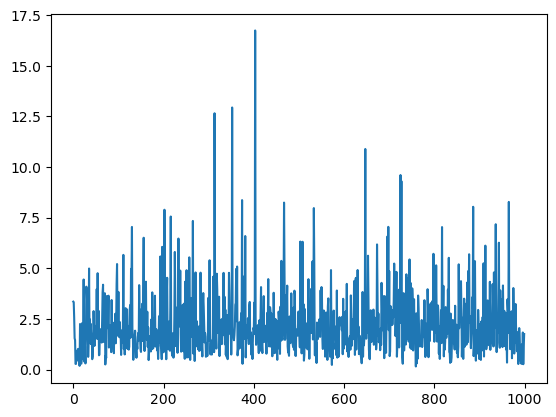

In [58]:
plt.plot(np.sum(v*v, axis = 0)/np.sum(u*u, axis= 0))